<a href="https://colab.research.google.com/github/monicaorduz/tutoriales/blob/master/Copia_de_Tema_3_4_Pipeline_desde_la_adquisici%C3%B3n_de_los_datos_hasta_la_respuesta_del_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

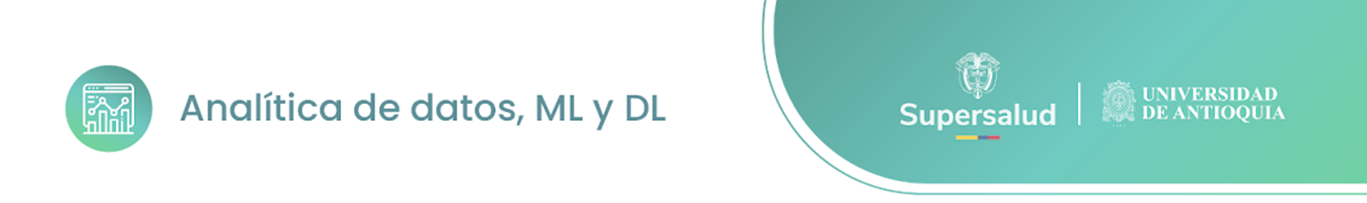

# **Pipeline: desde la adquisición de los datos hasta la respuesta del modelo**

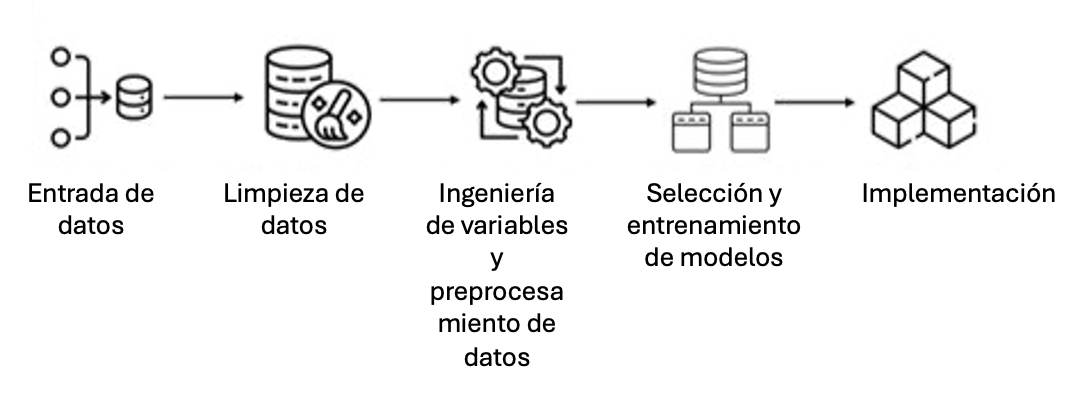

### **1. Cargar y realizar una limpieza básica del dataset financiero**

In [ ]:
# Carga de las librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Carga de la base de datos.
# Si está alojada en Drive use las siguientes instrucciones
from google.colab import drive
drive.mount('/content/drive')

path = '' # esta path hace referencia a la ruta donde está guardada la base de datos en su Drive

In [ ]:
# Si está trabajando en su computadora local, no tiene que ejecutar la celda anterior

#path = '' # Si no usa la celda anterior porque está en el local y la base de datos está en la misma carpeta del script, este path=''

# df_sns = pd.read_csv(path+'Datos_SNS_Ejerciciosv2.csv', encoding='ISO-8859-1', sep=';',  header=None) # abrimos el archivo
df_sns = pd.read_csv('Datos_SNS_Ejerciciosv2.csv', encoding='ISO-8859-1', sep=';',  header=None) # abrimos el archivo

cols = ['objectid','nit','razón_social','código_concepto','valor','catálogo','descripción_concepto','periodo_corte','fecha_reporte'] # títulos de las columnas
df_sns.columns = cols # renombramos las columnas del DataFrame
df_sns.head()

In [ ]:
df_sns.shape

### **2. Realizar un Análisis Exploratorio (EDA)**

In [ ]:
# Identificamos el tamaño del DataFrame, los tipos de datos y la cantidad de valores no nulos existentes
df_sns.info()

In [ ]:
# También se puede ver a la inversa, ¿Cuántos datos faltantes hay por variable?.
df_sns.isnull().sum()

In [ ]:
# En la limpieza de los datos podemos ver que existe la variable 'nit' y la 'razón_social'
# podemos empezar por identificar si hay equivalencia entre estas
df_sns.groupby(['nit','razón_social']).count()

Del análisis antetior podemos identificar que:

1. el NIT 837000084 está asociado a dos razones sociales:
    * IPS INDÍGENA MALLAMÁS
    * ips indígena mallamás

2. El NIT 800088702 Esá asociando a dos razones sociales, pero que aparentemente no hay diferencia en la escritura.
    * COMPAÑÍA SURAMERICANA DE SERVICIOS DE SALUD S.A. SUSALUD MEDICINA PREPAGADA
    * COMPAÑÍA SURAMERICANA DE SERVICIOS DE SALUD S.A. SUSALUD MEDICINA PREPAGADA

**Conclusiones de los hallazgos**
1. Es evidente que para el primer caso, el problema radica en que Python es sensible a mayúsculas y minúsculas, entonces el algoritmo está identificando a estas EPSs como diferentes.
2. Para el caso del segundo nombre, no hay una cambio evidente en la escritura, así que se suguiere sacar los nombre a parte y revisarlos uno por uno

In [ ]:
# sacamos los nombre en una lista para identificar caracteres diferentes.
df_sns['razón_social'].value_counts().index.sort_values()

Se puede observar que la diferencia con los nombre es que en uno, entre las palabras `"S.A.  SUSALUD"` hay un doble espacio, mientras que en el otro, el espacio es sencillo `"S.A. SUSALUD"`

In [ ]:
# Para hacer esa limpieza de datos y hacer que estos nombre sean iguales, podemos hacer una función y utilizar el método "apply()"
def limpiarNombresEPS(x):
    x = x.upper()
    x = x.replace('  ',' ')
    return x

In [ ]:
# Ahora aplicamos la función limpiarNombreEPS a la columna "razón_social"
df_sns['razón_social'] = df_sns['razón_social'].apply(limpiarNombresEPS)
df_sns.head()

In [ ]:
# Volvemos a revisar si hay nombres de EPS mal escritos
df_sns.groupby(['nit','razón_social']).count()

Podemos ver ahora que, a cada `NIT` le corresponde solo un nombre de `EPS`(*razón_social*)

**NOTA**: se puede hacer este mismo razonamiento con las variable `descripción_concepto` y `periodo_corte`. Tener en cuenta que entre más granularidad haya en los posibles valores que pueda tomar la variable, la tarea se hace más dispendiosa.

#### **¿Cuántas aseguradoras están reportando información?**

In [ ]:
# Podemos usar el método "value_counts()" con la variable "nit". Deberíamos obtener el mismo resultado con la variable "razón_social" luego de haber hecho la limpieza
df_sns.nit.value_counts()

In [ ]:
# Podemos graficar este resultado, así la visualización de la información puede ser más fácil.
# hacer una gráfica en barras donde las etiquetas del eje x están giradas 90°

plt.bar([str(i) for i in list(df_sns.nit.value_counts().index)], list(df_sns.nit.value_counts()))
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))  # 16 pulgadas de ancho x 8 de alto

bars = plt.bar([str(i) for i in list(df_sns.nit.value_counts().index)],
               list(df_sns.nit.value_counts()))

# Agregar etiquetas manualmente
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height}', ha='center', va='bottom', rotation=90)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### **¿Qué periodos trimestrales cubren los datos?**

In [ ]:
df_sns.periodo_corte.unique()

La base de datos suministrada tiene información contable de los periodos `PRIMER`, `SEGUNDO`, `TERCER` y `CUARTO` periodo de los años 2023 y 2024. Para el año 2025, la información corresponde a los periodos `PRIMER` y `SEGUNDO`, pero adicional también separados en los meses de `ENERO` a `JUNIO`

#### **¿Cuáles son los conceptos contables con mayores movimientos?**

In [ ]:
df_sns.código_concepto.value_counts()

El top 5 de las cuentas contables que más se repiten son:


| Orden | Código | Descripción | Tipo | Registros |
|-------|--------|-------------|------|-----------|
| 1 | 3 | PATRIMONIO | Patrimonio | 390 |
| 2 | 5103 | CONTRIBUCIONES EFECTIVAS | Ingresos | 389 |
| 3 | 510302 | APORTES A EPS | Ingresos | 389 |
| 4 | 24 | PROVISIONES | Pasivos | 389 |
| 5 | 510101 | SUELDOS | Gastos | 389 |

#### **¿Existen valores atípicos o inconsistentes en los montos reportados?**

In [ ]:
# ¿Existen valores atípicos o inconsistentes en los montos reportados?
# identificar valores atípicos en la variable "valor"
df_sns.valor.describe()


In [ ]:
df_sns.sort_values('valor')

1. Existe un monto negativo reportado por valor de: -$10.337.411.331.040 de la EPS `FAMISANAR LTDA. CAFAM - COLSUBSIDIO E.P.S.` por concepto de `RESULTADOS`

2. El monto positivo reportado con mayor valor es de: $20.279.681.124.333 de la EPS `NUEVA EMPRESA PROMOTORA DE SALUD S.A.` por concepto de `INGRESOS`

**NOTA:** validar con expertos si esto sí es posible en este contexto.

#### **¿Hay datos faltantes que requieran tratamiento?**

In [ ]:
df_sns.isnull().sum()

Haciendo el análisis de las variable que presentan datos faltantes, podemos concluir:

1. `objectid`: variable no requiere tratamiento de faltantes, es solo un indicador único del registro.
2. `descripción_concepto`: requiere una revisión, es posible que usando la variable `código_concepto` se pueda imputar.
3. `fecha_reporte`: no requiere tratamiento, es solo la fecha en que reportaron la información financiera, pero no da otro tipo de información relevante.

In [ ]:
def num2str(x):
    """Función para convertir campos numéricos en strings"""
    return str(x)

def str2num(x):
    """Función para convertir campos de strings en números enteros"""
    return int(x)

# Convertimos los números de los códigos PUC a enterors para poder buscar un str
df_sns['código_concepto'] = df_sns['código_concepto'].apply(num2str)

In [ ]:
# 4: "Ingresos"
# 5: "Gastos"
ingresos_20231 = 'Ingresos 1er trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='PRIMER TRIMESTRE 2023')].valor.sum()/1000000000000
ingresos_20232 = 'Ingresos 2do trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='SEGUNDO TRIMESTRE 2023')].valor.sum()/1000000000000
ingresos_20233 = 'Ingresos 3er trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='TERCER TRIMESTRE 2023')].valor.sum()/1000000000000
ingresos_20234 = 'Ingresos 4to trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='CUARTO TRIMESTRE 2023')].valor.sum()/1000000000000
ingresos_20241 = 'Ingresos 1er trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='PRIMER TRIMESTRE 2024')].valor.sum()/1000000000000
ingresos_20242 = 'Ingresos 2do trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='SEGUNDO TRIMESTRE 2024')].valor.sum()/1000000000000
ingresos_20243 = 'Ingresos 3er trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='TERCER TRIMESTRE 2024')].valor.sum()/1000000000000
ingresos_20244 = 'Ingresos 4to trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('4')) & (df_sns.periodo_corte=='CUARTO TRIMESTRE 2024')].valor.sum()/1000000000000

gastos_20231 = 'Gastos 1er trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='PRIMER TRIMESTRE 2023')].valor.sum()/1000000000000
gastos_20232 = 'Gastos 2do trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='SEGUNDO TRIMESTRE 2023')].valor.sum()/1000000000000
gastos_20233 = 'Gastos 3er trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='TERCER TRIMESTRE 2023')].valor.sum()/1000000000000
gastos_20234 = 'Gastos 4to trim 2023:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='CUARTO TRIMESTRE 2023')].valor.sum()/1000000000000
gastos_20241 = 'Gastos 1er trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='PRIMER TRIMESTRE 2024')].valor.sum()/1000000000000
gastos_20242 = 'Gastos 2do trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='SEGUNDO TRIMESTRE 2024')].valor.sum()/1000000000000
gastos_20243 = 'Gastos 3er trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='TERCER TRIMESTRE 2024')].valor.sum()/1000000000000
gastos_20244 = 'Gastos 4to trim 2024:' , df_sns[(df_sns.nit==800130907) & (df_sns.código_concepto.str.startswith('5')) & (df_sns.periodo_corte=='CUARTO TRIMESTRE 2024')].valor.sum()/1000000000000

In [ ]:
ingresos = [ingresos_20231[1],ingresos_20232[1],ingresos_20233[1],ingresos_20234[1],ingresos_20241[1],ingresos_20242[1],ingresos_20243[1],ingresos_20244[1]]
gastos = [gastos_20231[1],gastos_20232[1],gastos_20233[1],gastos_20234[1],gastos_20241[1],gastos_20242[1],gastos_20243[1],gastos_20244[1]]

plt.bar(['2023-1','2023-2','2023-3','2023-4','2024-1','2024-2','2024-3','2024-4',], ingresos, label='Ingresos')
plt.bar(['2023-1','2023-2','2023-3','2023-4','2024-1','2024-2','2024-3','2024-4',], gastos, label='Gastos')
plt.title('Ingresos Vs Gastos - trimestres 2023 y 2024 - SALUD TOTAL EPS-S S.A.-')
plt.ylabel('Pesos colombianos x e12')
plt.xlabel('Trimestres 2023 y 2024')
plt.legend()
plt.show()

In [ ]:
df_sns.isna().sum()

In [ ]:
df_sns.periodo_corte.unique()

# **🎯 PROYECTO: MODELO DE CLASIFICACIÓN - "SEMÁFORO DE RIESGO"**

### Objetivo: Predecir la categoría de riesgo de una aseguradora para el próximo trimestre.

Estamos prediciendo "RIESGO DE INCUMPLIMIENTO DE OBLIGACIONES Y PRESTACIÓN INADECUADA DE SERVICIOS DE SALUD", que se manifiesta en:

* Incapacidad para pagar siniestros y obligaciones

* Deterioro en la calidad del servicio a afiliados

* Incumplimiento de normas regulatorias

* Pérdida de sostenibilidad financiera y operativa

<br><br>
#### ¿Por qué es importante esta predicción?

Porque permite a la Superintendencia identificar tempranamente qué aseguradoras necesitan mayor supervisión, evitando crisis que afecten a los afiliados y al sistema de salud en general.

## **Feature Engineering y selección**

In [ ]:
# Lista para almacenar los resultados por trimestre y aseguradora
resultados = []

# Agrupar por aseguradora y período de corte
for (nit, periodo), grupo in df_sns.groupby(['nit', 'periodo_corte']):

    # Calcular indicadores para ESTE grupo específico (aseguradora + trimestre)
    try:
        # Activos corrientes (códigos que empiezan con 11)
        activos_corrientes = grupo[grupo['código_concepto'].str.startswith('11', na=False)]['valor'].sum()

        # Pasivos corrientes (códigos que empiezan con 21, 22, 23)
        pasivos_corrientes = grupo[grupo['código_concepto'].str.startswith('2', na=False)]['valor'].sum()

        # Activos totales (códigos que empiezan con 1)
        activos_totales = grupo[grupo['código_concepto'].str.startswith('1', na=False)]['valor'].sum()

        # Pasivos totales (códigos que empiezan con 2)
        pasivos_totales = grupo[grupo['código_concepto'].str.startswith('2', na=False)]['valor'].sum()

        # Ingresos (códigos que empiezan con 4)
        ingresos_totales = grupo[grupo['código_concepto'].str.startswith('4', na=False)]['valor'].sum()

        # Gastos (códigos que empiezan con 5)
        gastos_totales = grupo[grupo['código_concepto'].str.startswith('5', na=False)]['valor'].sum()

        # Calcular indicadores financieros con manejo de divisiones por cero
        liquidez = activos_corrientes / pasivos_corrientes if pasivos_corrientes != 0 else np.nan
        endeudamiento = pasivos_totales / activos_totales if activos_totales != 0 else np.nan
        utilidad_neta = ingresos_totales - gastos_totales
        rentabilidad = utilidad_neta / ingresos_totales if ingresos_totales != 0 else np.nan

        # Crear categorías de riesgo
        if pd.isna(liquidez) or pd.isna(endeudamiento) or pd.isna(rentabilidad):
            categoria_riesgo = 'SIN_DATOS'
        elif (liquidez > 1.5) and (endeudamiento < 0.6) and (rentabilidad > 0.1):
            categoria_riesgo = 'BAJO_RIESGO'
        elif (liquidez > 1.0) and (endeudamiento < 0.8) and (rentabilidad > 0.03):
            categoria_riesgo = 'MEDIO_RIESGO'
        else:
            categoria_riesgo = 'ALTO_RIESGO'

        # Agregar resultado
        resultados.append({
            'nit': nit,
            'razón_social': grupo['razón_social'].iloc[0] if 'razón_social' in grupo.columns else 'N/A',
            'periodo_corte': periodo,
            'liquidez': liquidez,
            'endeudamiento': endeudamiento,
            'utilidad_neta': utilidad_neta,
            'rentabilidad': rentabilidad,
            'categoria_riesgo': categoria_riesgo,
            'activos_corrientes': activos_corrientes,
            'pasivos_corrientes': pasivos_corrientes,
            'ingresos_totales': ingresos_totales,
            'gastos_totales': gastos_totales
        })

    except Exception as e:
        print(f"Error procesando {nit} - {periodo}: {e}")
        continue

# Crear DataFrame con resultados
df_indicadores = pd.DataFrame(resultados)

#return df_indicadores
print(" CALCULANDO INDICADORES POR TRIMESTRE Y ASEGURADORA...")
#df_indicadores = crear_target_clasificacion_por_trimestre(df_sns)

# Mostrar resultados
print(f" Indicadores calculados para {len(df_indicadores)} combinaciones aseguradora-trimestre")
print(f" Aseguradoras únicas: {df_indicadores['nit'].nunique()}")
print(f" Trimestres únicos: {df_indicadores['periodo_corte'].nunique()}")

In [ ]:
print("ANÁLISIS DE CLASIFICACIÓN POR RIESGO")
print("=" * 50)

# Distribución por categoría de riesgo
distribucion = df_indicadores['categoria_riesgo'].value_counts()
print("\nDistribución de categorías de riesgo:")
for categoria, count in distribucion.items():
    porcentaje = (count / len(df_indicadores)) * 100
    print(f"  {categoria}: {count} registros ({porcentaje:.1f}%)")

# Distribución por trimestre
print(f"\nPeríodos analizados: {df_indicadores['periodo_corte'].nunique()} trimestres")
print("Trimestres únicos:", df_indicadores['periodo_corte'].unique())

# Estadísticas de indicadores por categoría
if len(df_indicadores) > 0:
    print(f"\nEstadísticas por categoría de riesgo:")
    indicadores = ['liquidez', 'endeudamiento', 'rentabilidad']

    for categoria in df_indicadores['categoria_riesgo'].unique():
        df_cat = df_indicadores[df_indicadores['categoria_riesgo'] == categoria]
        print(f"\n {categoria} ({len(df_cat)} registros):")

        for indicador in indicadores:
            if indicador in df_cat.columns:
                media = df_cat[indicador].mean()
                if not pd.isna(media):
                    print(f"   {indicador}: {media:.3f}")

In [ ]:
condiciones = [
        (df_indicadores['liquidez'] > 1.5) & (df_indicadores['endeudamiento'] < 0.6) & (df_indicadores['rentabilidad'] > 0.1),
        (df_indicadores['liquidez'] > 1.0) & (df_indicadores['endeudamiento'] < 0.8) & (df_indicadores['rentabilidad'] > 0.03),
        (df_indicadores['liquidez'] <= 1.0) | (df_indicadores['endeudamiento'] >= 0.8) | (df_indicadores['rentabilidad'] <= 0.03)
    ]

categorias = ['BAJO_RIESGO', 'MEDIO_RIESGO', 'ALTO_RIESGO']
df_indicadores['categoria_riesgo'] = np.select(condiciones, categorias, default='MEDIO_RIESGO')

In [ ]:
df_indicadores.head()

In [ ]:
df_indicadores.categoria_riesgo.value_counts()

# **Machine Learning**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librería para entrenamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Librería para entandarización y codificación de variables
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
#

import warnings
warnings.filterwarnings('ignore')


In [ ]:
scaler = StandardScaler()
le = LabelEncoder()
test_size=0.3
random_state=42

# 1. Seleccionar características numéricas
feature_columns = ['liquidez', 'endeudamiento', 'utilidad_neta', 'rentabilidad']

# Verificar que las columnas existen
available_features = [col for col in feature_columns if col in df_indicadores.columns]
print(f"Características disponibles: {available_features}")

X = df_indicadores[available_features]

# 2. Variable objetivo
if 'categoria_riesgo' not in df_indicadores.columns:
    raise ValueError("La columna 'categoria_riesgo' no existe en el DataFrame")

y = le.fit_transform(df_indicadores['categoria_riesgo'])

# 3. Manejar valores NaN
X = X.fillna(X.median())

# 4. Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

# 5. Escalar características
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Datos preparados:")
print(f"   - Train: {X_train.shape}")
print(f"   - Test: {X_test.shape}")
print(f"   - Clases: {np.unique(y)} -> {le.classes_}")



## **Regresión Logística**

In [ ]:
modelos = {} # Dicccionario para guardar los resultados de las métricas

# Regresión Logística
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, max_iter=1000)
# Entrenar modelo
lr.fit(X_train_scaled, y_train)

# Predecir
y_pred = lr.predict(X_test_scaled)
y_pred_proba = lr.predict_proba(X_test_scaled)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Validación cruzada
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Guardar resultados
modelos['lr'] = {
    'accuracy': accuracy,
    'f1_score': f1,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
}

print("************* REGRESIÓN LOGÍSTICA **************")
print(f" Accuracy: {accuracy:.4f} - F1: {f1:.4f} - CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


In [ ]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,           # Mostrar números en las celdas
            fmt='d',              # Formato decimal
            cmap='Blues',         # Mapa de colores
            cbar=True,            # Barra de colores
            square=True,          # Celdas cuadradas
            linewidths=0.5,       # Ancho de líneas
            linecolor='white')    # Color de líneas

# Personalizar el heatmap
plt.title('Matriz de Confusión - Regresión Logística', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)

# Si tienes los nombres de las clases (bajo, medio, alto riesgo)
# Reemplaza con tus categorías reales
categorias = ['Bajo Riesgo', 'Medio Riesgo', 'Alto Riesgo']  # Ajusta según tus categorías

# Si sabes las categorías reales, descomenta estas líneas:
# plt.xticks(ticks=np.arange(len(categorias)) + 0.5, labels=categorias, rotation=0)
# plt.yticks(ticks=np.arange(len(categorias)) + 0.5, labels=categorias, rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
target_name = ['ALTO_RIESGO','MEDIO_RIESGO','BAJO_RIESGO']

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

print(classification_report(y_test, y_pred, target_names=target_name))

## **Random Forest**

## **SVM - Support Vector Machine**

## **K Nearest Neighbors - KNN**

## **Decision Tree**

## **XGBoost - Extreme Gradient Boosting**

# **Deep Learning**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Preparar la red neuronal
# 1. Entrenar modelo final con todos los datos de entrenamiento
print(" Entrenando modelo final...")
model_final = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model_final.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_final.summary()

In [ ]:
history_final = model_final.fit(X_train_scaled, y_train,
                               epochs=100,
                               batch_size=32,
                               validation_data=(X_test_scaled, y_test),
                               verbose=1,
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=15)])



In [ ]:
# 2. Calcular Validación Cruzada en paralelo
print("\n Calculando Validación Cruzada...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kfold.split(X_train_scaled):
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    model_cv = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')
    ])

    model_cv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model_cv.fit(X_fold_train, y_fold_train, epochs=50, batch_size=32, verbose=0)
    _, acc = model_cv.evaluate(X_fold_val, y_fold_val, verbose=0)
    cv_scores.append(acc)

# 3. Calcular métricas finales
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Evaluar modelo final en test set
test_loss, test_accuracy = model_final.evaluate(X_test_scaled, y_test, verbose=0)

# Calcular F1-Score
y_pred_proba = model_cv.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')

# Guardar resultados
modelos['ann'] = {
    'accuracy': test_accuracy,
    'f1_score': f1,
    'cv_mean': cv_mean, #cv_scores.mean(),
    'cv_std': cv_std, #cv_scores.std(),
}

print(f"\n🎯 MÉTRICAS FINALES:")
print(f"   Test Accuracy:    {test_accuracy:.4f}")
print(f"   F1 Scores:        {f1:.4f}")
print(f"   CV Mean Accuracy: {cv_mean:.4f}")
print(f"   CV Std:          ±{cv_std:.4f}")


## **Comparativo de las métricas**

In [ ]:
modelos_df = pd.DataFrame(modelos).T
modelos_df.sort_values(by='accuracy', ascending=False, inplace=True)
modelos_df